In [1]:
import add_to_syspath
import tensorflow as tf
import tensorflow.keras.backend as K
from lucid.modelzoo import audio_base
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform_audio2 as ta2
from tqdm import tqdm

In [2]:
import numpy as np

In [3]:
model = audio_base.Model.load("../models/audionet2_lucid/frozen_graph_inference.pb")

Tensor("rfft_2:0", shape=(4001,), dtype=complex64)
Tensor("ExpandDims_5:0", shape=(1, 8000, 1), dtype=float32)


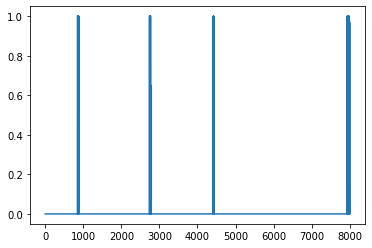

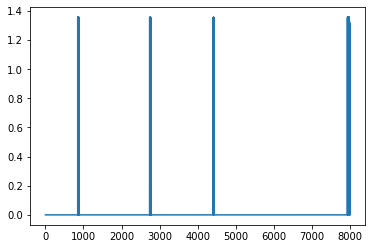

In [58]:
#transforms = ta2.standard_transforms
def vertical_scaling(scales, seed=None):
    def inner(t):
        t = tf.convert_to_tensor(t, preferred_dtype=tf.float32)
        scale = ta2._rand_select(scales, seed=seed)
        return scale*t
    return inner

# Build a dataflow graph.
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = vertical_scaling([2.])(c)
f = horizontal_scaling()(vis)

# Construct a `Session` to execute the graph.
sess = tf.Session()

# Execute the graph and store the value that `e` represents in `result`.
r = sess.run(f)
import matplotlib.pyplot as plt
plt.plot(vis[0,:,0])
plt.show()
plt.plot(r[0,:,0])
plt.show()

def horizontal_scaling(seed=None):
    def inner(t):
        freq = tf.signal.rfft(t[0,:,0])
        print(freq)
        changed_freq = tf.constant([freq[0,i*,0]])
        res = tf.expand_dims(tf.expand_dims(tf.signal.irfft((np.random.random()+0.5)*freq), 0), -1)
        print(res)
        return res
    return inner

transforms = [vertical_scaling([1 + (i - 5) / 50. for i in range(11)]), horizontal_scaling()]

In [54]:
with tf.Graph().as_default() as graph, tf.Session() as sess:
    T = render.make_vis_T(model, objectives.channel("conv5/Relu",2) + objectives.channel("conv5/Relu",5), param_f=lambda : param.audio(8000), transforms=transforms, relu_gradient_override=True) 
    
    loss, vis_op, t_audio = T("loss"), T("vis_op"), T("input")
    tf.global_variables_initializer().run()
    
    try:
        for i in tqdm(range(1000)):
            loss_, _ = sess.run([loss, vis_op])
            
        vis = t_audio.eval()
        print(loss_)
        
    except KeyboardInterrupt:
        log.warning("Interrupted optimization at step {:d}.".format(i+1))
        vis = t_audio.eval()
        show(np.hstack(vis))

Tensor("rfft:0", shape=(4001,), dtype=complex64)
Tensor("ExpandDims_1:0", shape=(1, 8000, 1), dtype=float32)


100%|██████████| 1000/1000 [02:07<00:00,  5.49it/s]


0.0040651225


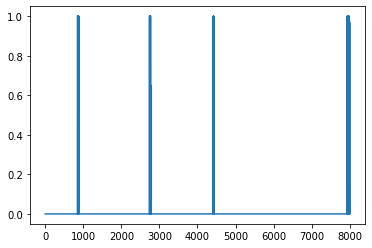

In [55]:
import matplotlib.pyplot as plt
plt.plot(vis[0,:,0])
from IPython.display import Audio
Audio(vis[0,:,0], rate=8000)

In [6]:
model.show_graph()